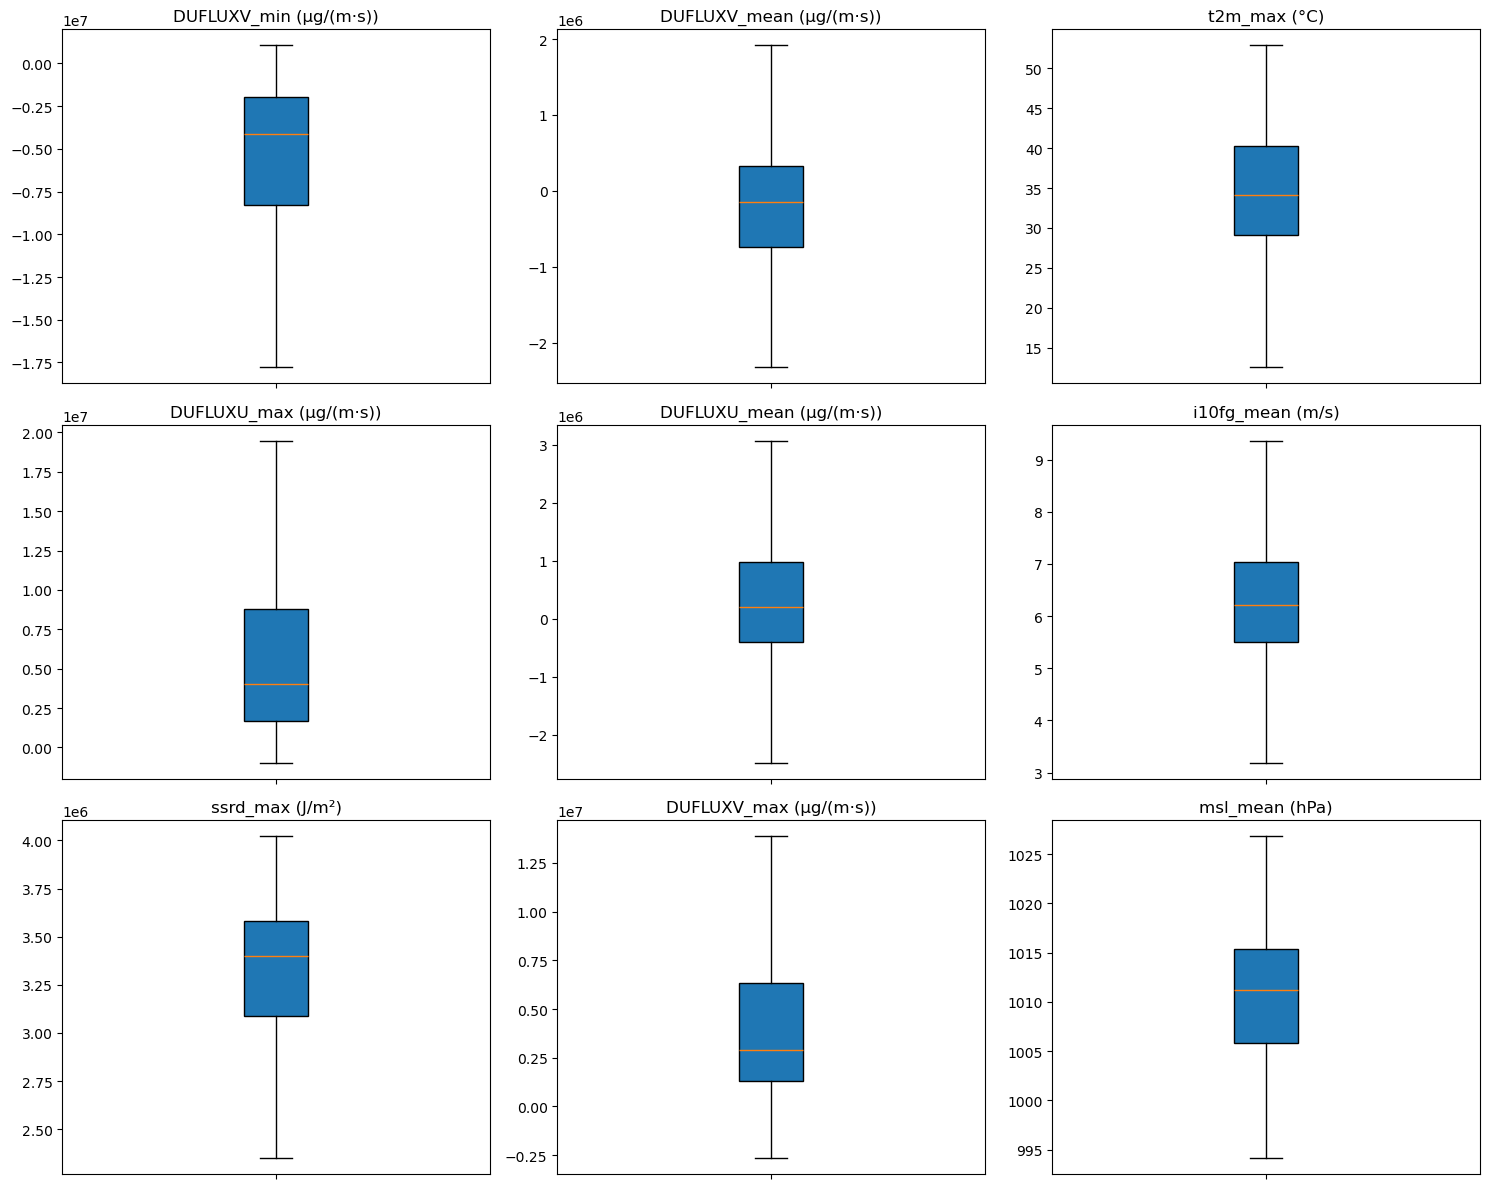

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import math

# ------------------------- CONFIGURATION -------------------------
base_path = r"Z:\Thesis\Data\ML_Data\AP_training2"
output_dir = r"Z:\Thesis\Data\test\DustCast\SFC\DC_v0063\boxplots\top10_feat"
os.makedirs(output_dir, exist_ok=True)

train_years = [
    1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
    1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
    2000,
    2013, 2014, 2015, 2016, 2017, 2018, 2019, 
    2020, 2021, 2022, 2023
]

countries = [
    "Yemen", 
    "Bahrain", 
    "Kuwait", 
    "Oman", 
    "Qatar", 
    "Saudi_Arabia", 
    "United_Arab_Emirates"
]

# In the original file the columns include suffixes like _min, _max, _mean.
# Here is the list of variables we want to process:
desired_vars = [
    "DUFLUXV_min", "DUFLUXV_mean", "t2m_max", 
    "DUFLUXU_max", "DUFLUXU_mean", "i10fg_mean", "ssrd_max", "DUFLUXV_max", "msl_mean"
]

# ------------------------- DATA LOADING & COMBINING -------------------------
all_dfs = []
for country in countries:
    for yr in train_years:
        file_path = os.path.join(
            base_path, 
            str(yr), 
            f"{country}_{yr}_surface_monthly_stats_merged.parquet"
        )
        if os.path.exists(file_path):
            try:
                df = pd.read_parquet(file_path)
                all_dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
        else:
            print(f"File does not exist: {file_path}")

if not all_dfs:
    raise ValueError("No data files loaded!")

df_all = pd.concat(all_dfs, ignore_index=True)

# Ensure all columns are numeric where applicable
for col in df_all.columns:
    df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

# ------------------------- SELECT DESIRED VARIABLES -------------------------
def get_existing_col(df, colname):
    if colname in df.columns:
        return colname
    alt = colname.upper()
    if alt in df.columns:
        return alt
    alt = colname.lower()
    if alt in df.columns:
        return alt
    return None

existing_vars = []
for var in desired_vars:
    col = get_existing_col(df_all, var)
    if col is not None:
        existing_vars.append(col)
    else:
        print(f"Warning: Variable '{var}' not found in the data.")

if not existing_vars:
    raise ValueError("None of the desired variables were found in the data.")

df_selected = df_all[existing_vars].copy()

# ------------------------- UNIT CONVERSIONS -------------------------
if get_existing_col(df_selected, "t2m_max") is not None:
    df_selected[get_existing_col(df_selected, "t2m_max")] = df_selected[get_existing_col(df_selected, "t2m_max")] - 273.15

if get_existing_col(df_selected, "msl_mean") is not None:
    df_selected[get_existing_col(df_selected, "msl_mean")] = df_selected[get_existing_col(df_selected, "msl_mean")] / 100

# Convert dust flux variables from kg/(m·s) to µg/(m·s) by multiplying by 1e9.
dust_flux_cols = ["DUFLUXV_min", "DUFLUXV_mean", "DUFLUXU_max", "DUFLUXU_mean", "DUFLUXV_max"]
for col in dust_flux_cols:
    existing = get_existing_col(df_selected, col)
    if existing is not None:
        df_selected[existing] = df_selected[existing] * 1e9

# ------------------------- CREATE SERIES & DEFINE UNITS -------------------------
variable_series = {}
for var in desired_vars:
    col = get_existing_col(df_selected, var)
    if col is not None:
        variable_series[var] = df_selected[col].dropna()

variable_units = {
    "DUFLUXV_min": "µg/(m·s)",
    "DUFLUXV_mean": "µg/(m·s)",
    "t2m_max": "°C",
    "DUFLUXU_max": "µg/(m·s)",
    "DUFLUXU_mean": "µg/(m·s)",
    "i10fg_mean": "m/s",
    "ssrd_max": "J/m²",
    "DUFLUXV_max": "µg/(m·s)",
    "msl_mean": "hPa"
}

# ------------------------- FACET WRAPPED BOX PLOTS -------------------------
n_vars = len(variable_series)
ncols = 3
nrows = math.ceil(n_vars / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*4))
axes = np.array(axes).reshape(-1)

for i, (var, series) in enumerate(variable_series.items()):
    ax = axes[i]
    ax.boxplot(series, notch=False, patch_artist=True, showfliers=False)
    unit = variable_units.get(var, "")
    ax.set_title(f"{var} ({unit})")
    ax.set_xticklabels([])

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
save_path = os.path.join(output_dir, "SFC_top10_tree_feature_boxplots.png")
plt.savefig(save_path)
plt.show()
plt.close(fig)

# ------------------------- COMPUTE SUMMARY STATISTICS -------------------------
# For each variable, compute count, min, 25th percentile, median, 75th percentile, mean, standard deviation, and variability range.
stats_list = []
for var, series in variable_series.items():
    stats = {
         "Variable": var,
         "Count": series.count(),
         "Min": series.min(),
         "25th Percentile": series.quantile(0.25),
         "Median": series.median(),
         "75th Percentile": series.quantile(0.75),
         "Mean": series.mean(),
         "Max": series.max(),
         "Std": series.std(),
         "Variability Range": series.max() - series.min()
    }
    stats_list.append(stats)

stats_df = pd.DataFrame(stats_list)
csv_path = os.path.join(output_dir, "SFC_top10_tree_feature_boxplot_stats.csv")
stats_df.to_csv(csv_path, index=False)
